In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
a = -1.0
b = 1.0
N = 11
x = np.linspace(a, b, N).reshape((-1, 1))
y = np.linspace(a, b, N).reshape((-1, 1))
xx, yy = np.meshgrid(x, y)
x = xx.reshape((-1, 1))
y = yy.reshape((-1, 1))

In [3]:
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    return [(rs.randn(insize, outsize) * scale,   # W
             rs.randn(outsize) * scale)           # b
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

params = init_random_params(0.1, layer_sizes=[2, 20, 20, 20, 1])

def u(params, x, y):
    inputs = np.concatenate((x, y), axis=1)
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs

In [4]:
u_x = elementwise_grad(u, 1)
u_xx = elementwise_grad(u_x, 1)
u_y = elementwise_grad(u, 2)
u_yy = elementwise_grad(u_y, 2)

In [6]:
def objective(params, step):
    res = u_xx(params, x, y) + u_yy(params, x, y) + 2
    bc0 = u(params, np.linspace(a, b, N).reshape((-1, 1)), np.broadcast_to(np.array([a]),(N,1)))
    bc1 = u(params, np.linspace(a, b, N).reshape((-1, 1)), np.broadcast_to(np.array([b]),(N,1)))
    bc2 = u(params, np.broadcast_to(np.array([a]),(N,1)), np.linspace(a, b, N).reshape((-1, 1)))
    bc3 = u(params, np.broadcast_to(np.array([b]),(N,1)), np.linspace(a, b, N).reshape((-1, 1)))
    return (np.mean(res**2)) + np.sum(bc0**2) + np.sum(bc1**2) + np.sum(bc2**2) + np.sum(bc3**2)


In [8]:
def callback(params, step, g):
        if step % 1000 == 0:
            print("Iteration {0:3d} objective {1}".format(step,
                                                          objective(params, step)))

In [18]:
params = adam(grad(objective), params,
          step_size=0.001, num_iters=2000, callback=callback)

Iteration   0 objective 0.0009680967159084715
Iteration 1000 objective 0.0009182795882853641


In [35]:

h = k = 0.2
def gera_u(U, M, N, a, b):
    res = np.zeros((M, N))
    x = np.linspace(a, b, N).reshape((-1, 1))
    y = np.linspace(a, b, N).reshape((-1, 1))
    for j in range(0, M):
        for i in range(0, N):
            res[j][i] = U(params, [x[j]], [y[i]])[0][0]
    return res
def gera_ticks(l, ini, end):
    ticks = ["" for x in range(l)]
    elementos = np.linspace(ini, end, int((end-ini)/0.2 + 1))
    ii = 0
    for i in range(l):
        if i % int(np.around(len(ticks)/len(elementos))) == 0:
            if ii >= len(elementos):
                break
            ticks[i] = elementos[ii].round(2)
            ii +=1
    # print(ticks)
    return ticks

def print_res(res, M, N, i, a, b, h, k, metodo="", print_annot=False, title=False):
    x_ticks = gera_ticks(int((a-i)/h + 1), i, a)
    y_ticks = gera_ticks(int((a-i)/k + 1), i, b)
    if not(title):
        title = 'Solução '+ metodo + ' h=' + str(h) + ' k=' + str(k)
    else:
        title = metodo + ' h=' + str(h) + ' k=' + str(k)

    plt.figure(dpi=200, figsize=(8, 6))
    plt.title(title)
    if print_annot:
        text = [ [ None for y in range( N+1 ) ] for x in range( M+1 ) ]
        for i in range(N+1):
            for j in range(M+1):
             text[i][j] = "U{},{}".format(i, j)
    else:
        text = False
    ax = sns.heatmap(res, cmap='jet', annot=text, fmt ='', xticklabels =1, yticklabels =1,cbar_kws={'label': 'Temperatura (ºC)'})
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    ax.invert_yaxis()
    plt.show()

# print_res(res, N, N, -1, 1, 1, h, k, metodo="Rede", print_annot=False)

(11, 11)


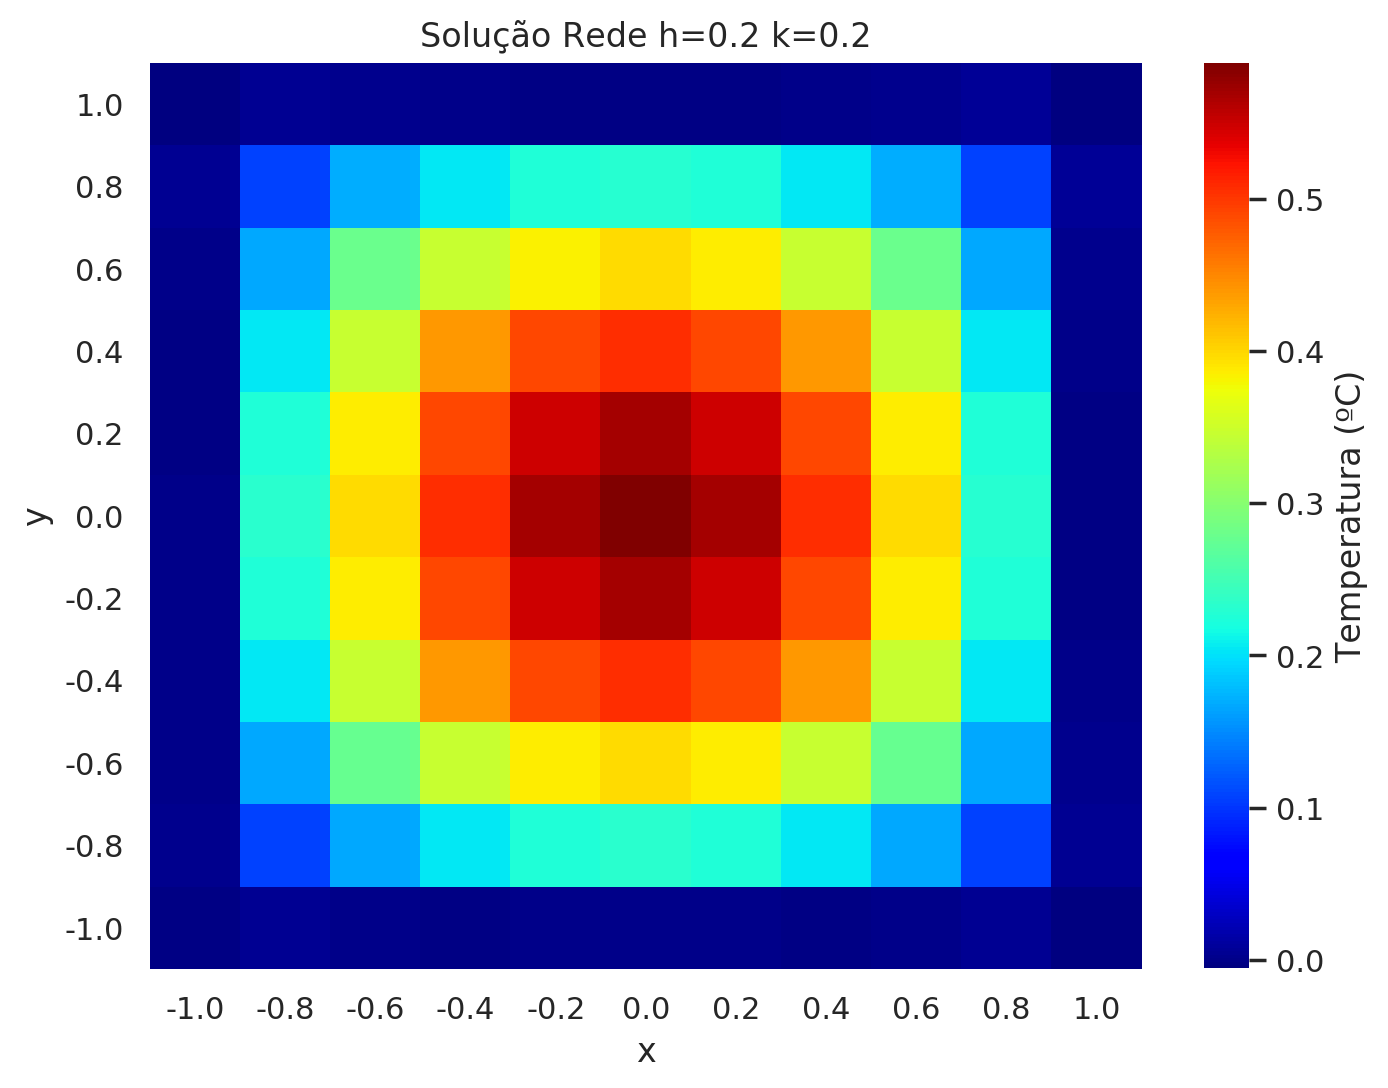

In [36]:
res = gera_u(u, N, N, a, b)
# print(u(params, [[0.1]], [[0.1]])[0][0])
print(res.shape)
print_res(res, N, N, -1, 1, 1, h, k, metodo="Rede", print_annot=False)

In [37]:
def soma(x, y):
    s = 0
    for n in range(0, 101):
        s+=(((-1)**n)/(2*n+1)**3) * (1/np.cosh(((2*n+1)*np.pi)/2))*np.cosh(((2*n+1)*np.pi*x)/2)*np.cos(((2*n+1)*np.pi*y)/2)
    return s

def sol_analitica(ini, a, b, h, k, M, N):
    u = np.zeros((M+1, N+1))
    x = np.linspace(ini, a, int((a-ini)/h)+1)
    y = np.linspace(ini, b, int((b-ini)/k)+1)
    print(x)
    for i in range(len(x)):
        for j in range(len(y)):
#             print(x[i], y[j])
            u[i, j] = 1 - y[j]**2 - (32/np.pi**3) * soma(x[i], y[j])
    return u    

u_a = sol_analitica(-1, 1, 1, h, k, N-1, N-1)
print_res(u_a, N, N, -1, 1, 1, h, k, metodo="Solução Analítica", print_annot=False, title=True)

[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]


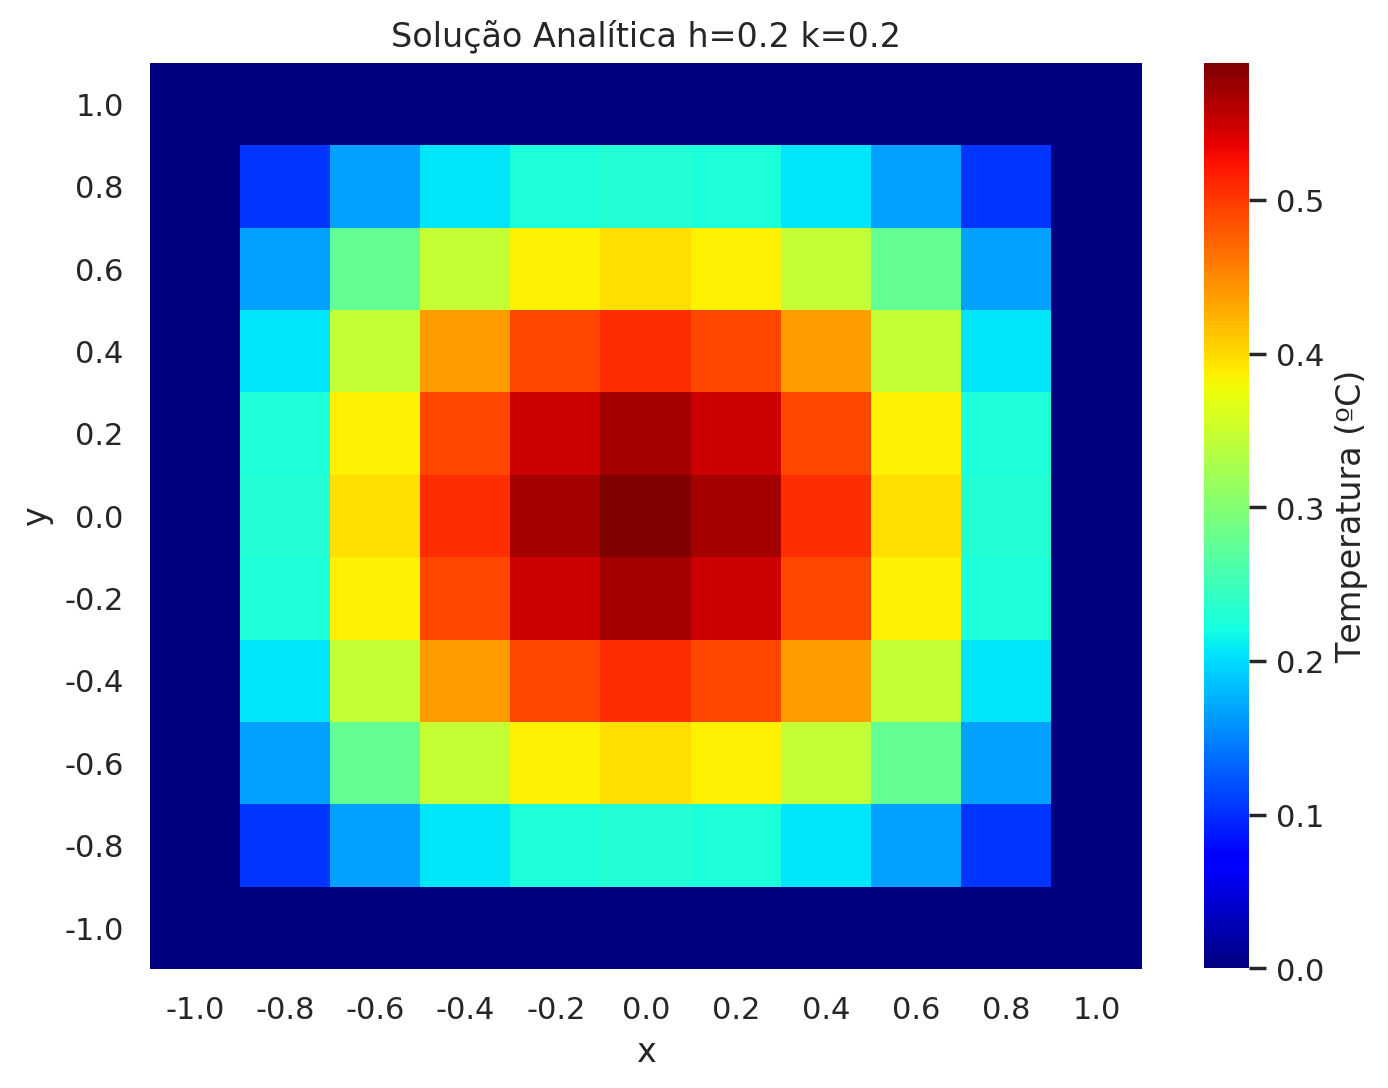

In [38]:
print_res(u_a, N, N, -1, 1, 1, h, k, metodo="Solução Analítica", print_annot=False, title=True)

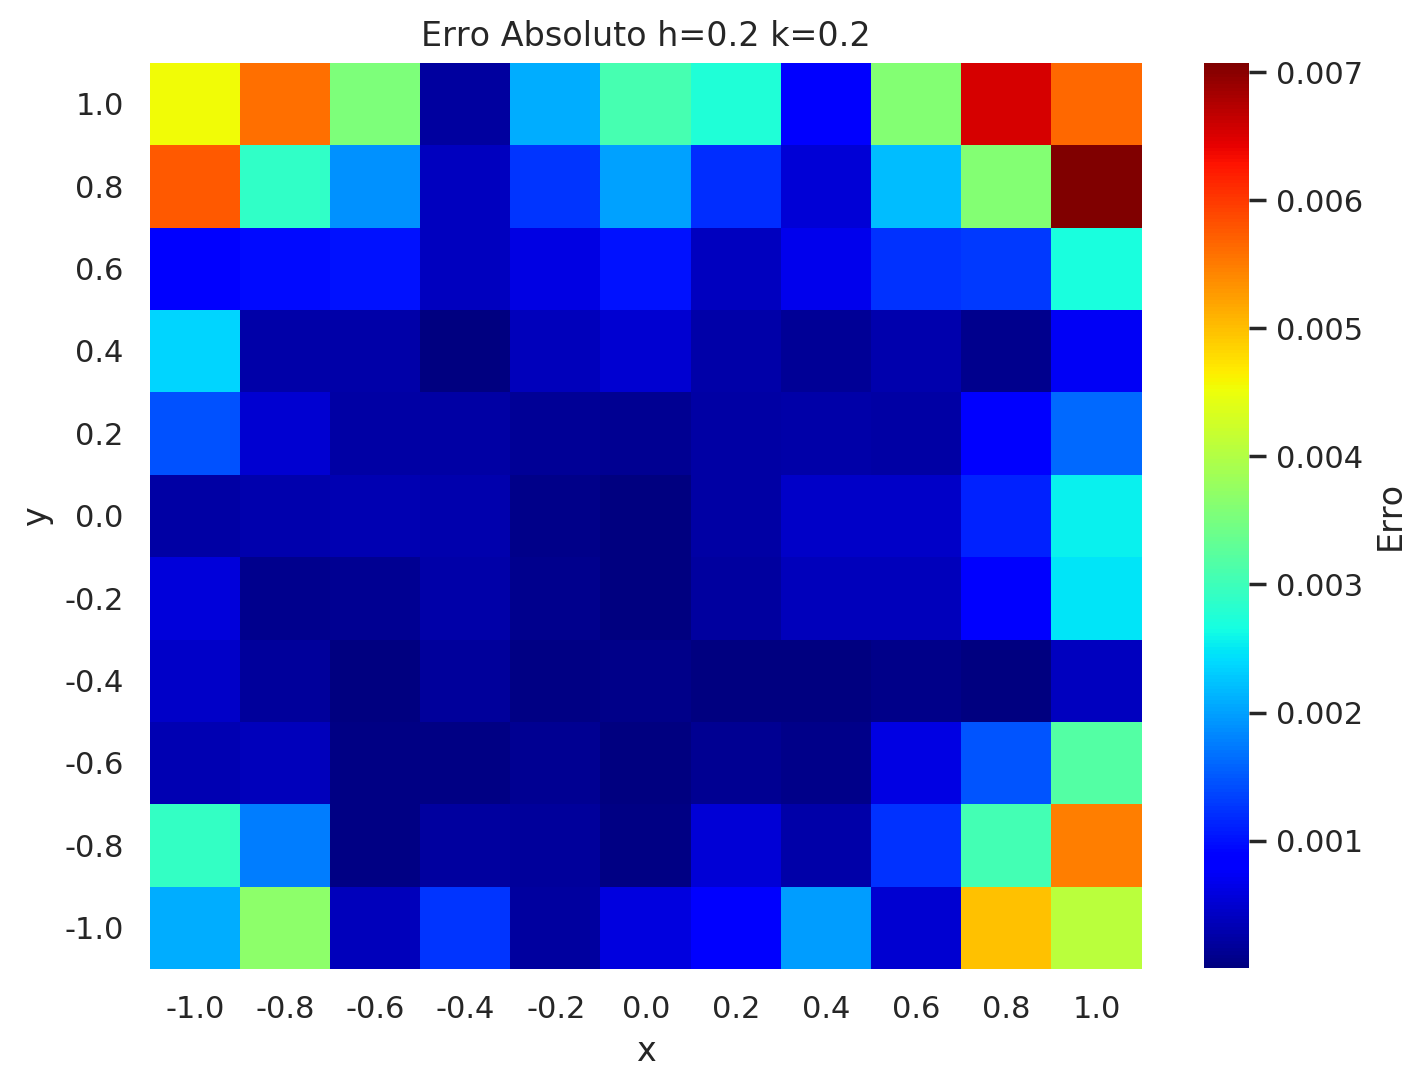

In [40]:
erro = np.absolute(u_a-res)


x_ticks = gera_ticks(int((2)/h + 1), -1, 1)
y_ticks = gera_ticks(int((2)/k + 1), -1, 1)
title = 'Erro Absoluto' + ' h=' + str(h) + ' k=' + str(k)

plt.figure(dpi=200, figsize=(8, 6))
plt.title(title)
ax = sns.heatmap(erro, cmap='jet', xticklabels =1, yticklabels =1,cbar_kws={'label': 'Erro'})

ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.yticks(rotation=0)
plt.xticks(rotation=0)

ax.invert_yaxis()
plt.show()

(41, 41)


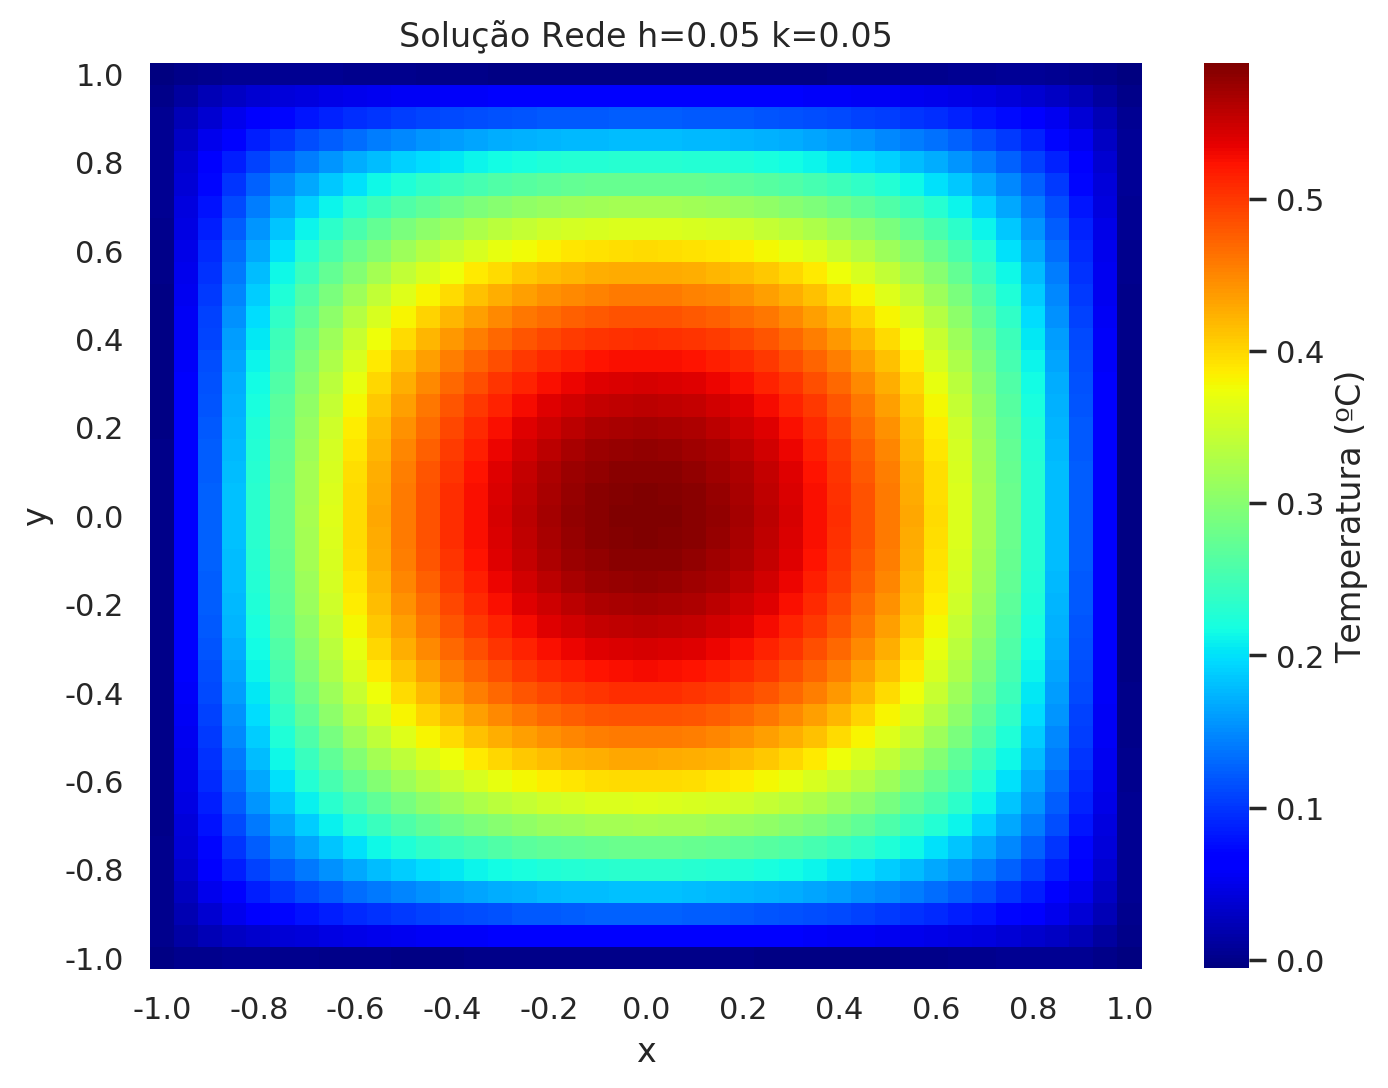

In [55]:
N = 41
h = k = 0.05
res = gera_u(u, N, N, a, b)
# print(u(params, [[0.1]], [[0.1]])[0][0])
print(res.shape)
print_res(res, N, N, -1, 1, 1, h, k, metodo="Rede", print_annot=False)

[-1.   -0.95 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45
 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15
  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75
  0.8   0.85  0.9   0.95  1.  ]


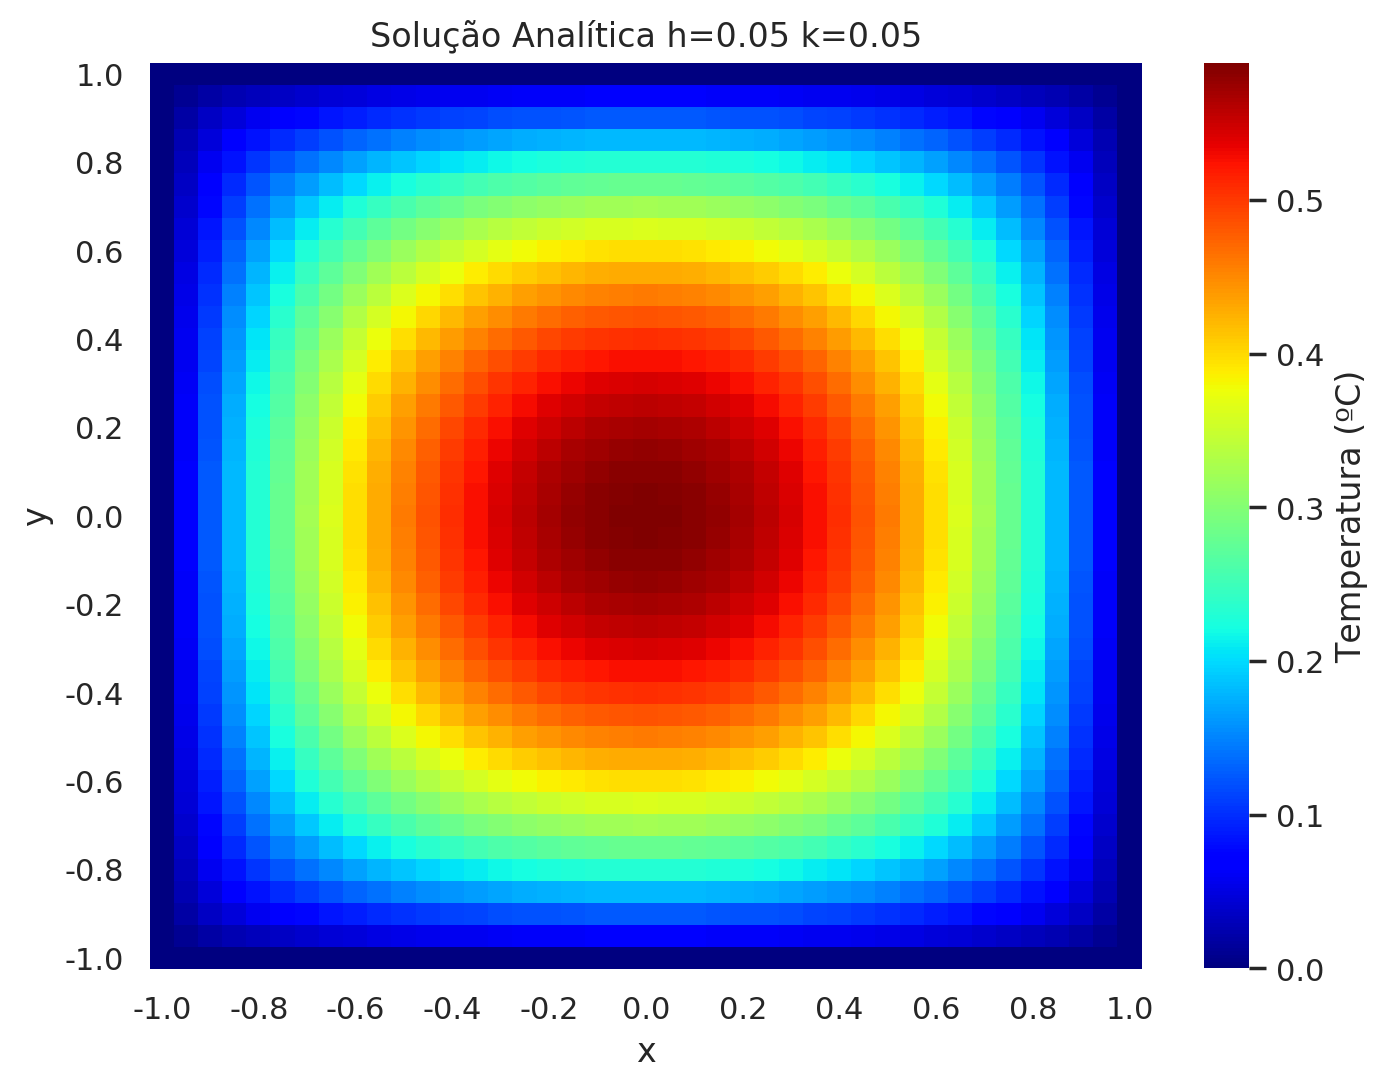

In [57]:
u_a = sol_analitica(-1, 1, 1, h, k, N-1, N-1)
print_res(u_a, N, N, -1, 1, 1, h, k, metodo="Solução Analítica", print_annot=False, title=True)

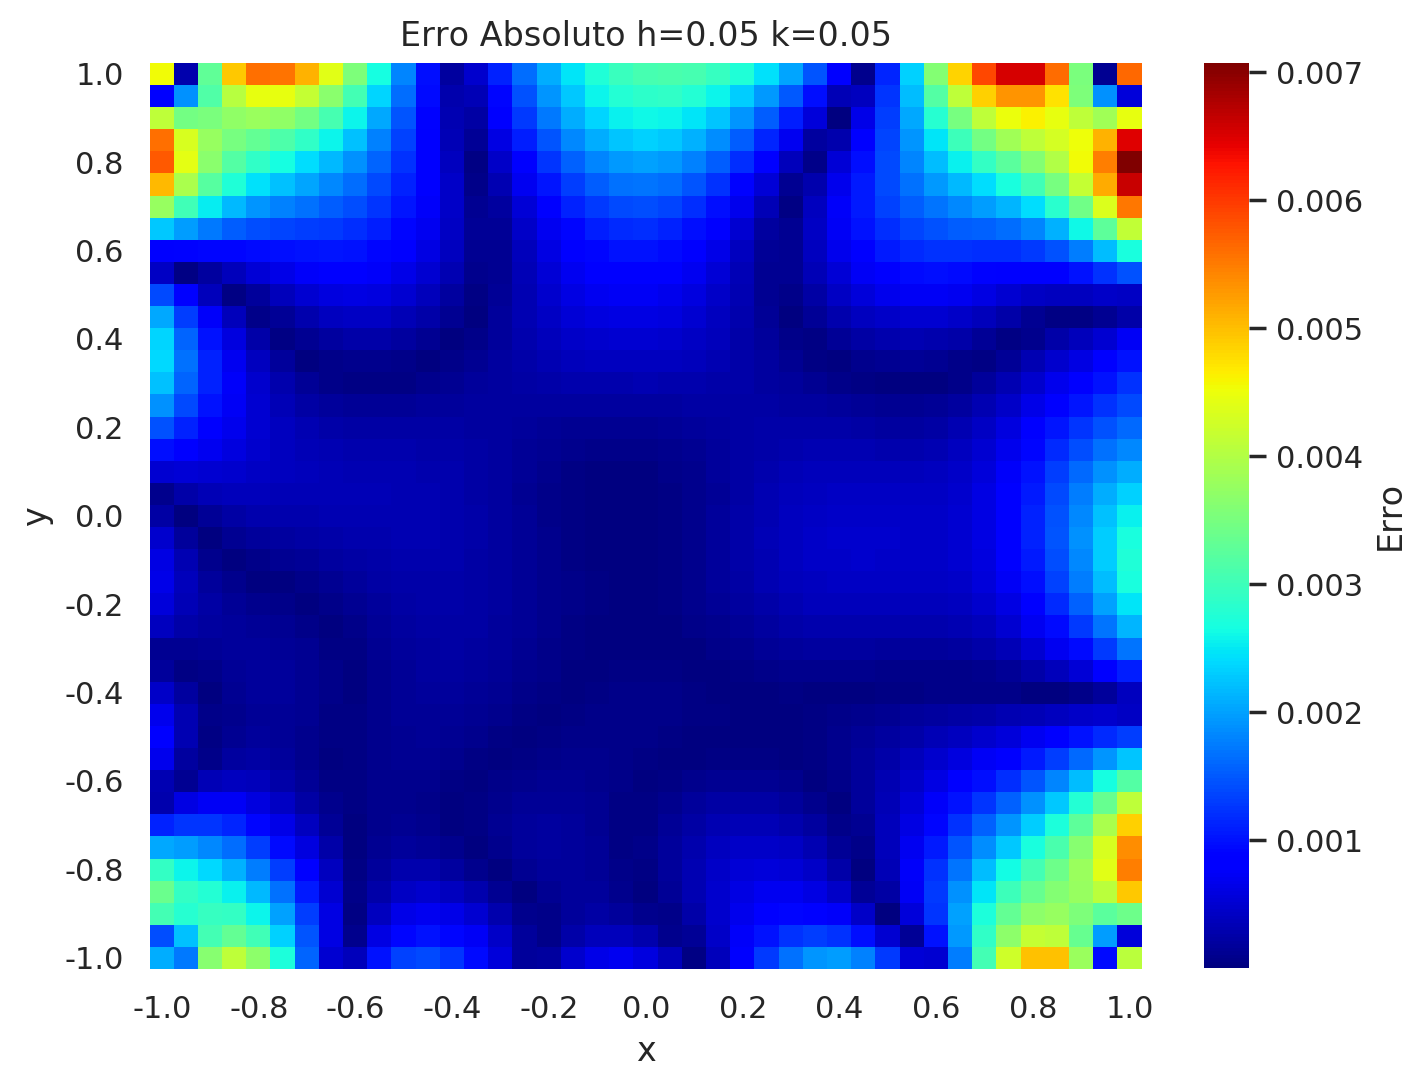

In [58]:
erro = np.absolute(u_a-res)


x_ticks = gera_ticks(int((2)/h + 1), -1, 1)
y_ticks = gera_ticks(int((2)/k + 1), -1, 1)
title = 'Erro Absoluto' + ' h=' + str(h) + ' k=' + str(k)

plt.figure(dpi=200, figsize=(8, 6))
plt.title(title)
ax = sns.heatmap(erro, cmap='jet', xticklabels =1, yticklabels =1,cbar_kws={'label': 'Erro'})

ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.yticks(rotation=0)
plt.xticks(rotation=0)

ax.invert_yaxis()
plt.show()